# Classifying cancer expression vectors

In this assignment you will train a neural network to identify the tissue type that produced an RNA expression vector. The dataset is comprised of RNA-seq data obtained from tumors.

For a complete description of the data collection workflow see this page:
https://xenabrowser.net/datapages/?host=https://toil.xenahubs.net

And for the corresponding publication:
https://doi.org/10.1038/nbt.3772

In [ ]:
import sys
import numpy as np
from math import log2
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import pandas as pd
import h5py
import seaborn as sns
import os
from sklearn.model_selection import StratifiedShuffleSplit
import torch
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

print("USING pytorch VERSION: ", torch.__version__)

USING pytorch VERSION:  1.7.0+cu101


## Loading and parsing training data
For this problem, expression data needs to be loaded and pruned. Initially, there are >50,000 genes in each expression vector, which can be reduced to a much smaller gene set for the sake of minimizing computation time. Here, the data is subsetted to only include genes from the KEGG gene set. You may want to consider reducing or expanding this dataset to get a better understanding of which genes are predictive, though this is not a requirement for the assignment.

For a list of gene sets, check out the MSigDB collections page: http://software.broadinstitute.org/gsea/msigdb/collections.jsp

This script was adapted from Rob Currie's ingestion script: https://github.com/rcurrie/tumornormal/blob/master/genesets.ipynb

We have placed a subset of this data for this homework in Google drive, you can download it here:

https://drive.google.com/drive/folders/1pPABQDEHCddPTJAhfD6G5KyBDJiK3unQ?usp=sharing

In [ ]:
# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#x_test: https://drive.google.com/file/d/1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW/view?usp=sharing
#x_train: https://drive.google.com/file/d/1s8VvRaUc62OYukRunV689Y9u-v_y7KRl/view?usp=sharing
#y_test: https://drive.google.com/file/d/1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2/view?usp=sharing
#t_train: https://drive.google.com/file/d/1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD/view?usp=sharing

# 2. Now proxy the Google Drive files to a local file
x_test_import = drive.CreateFile({'id':'1Cc4zEw1wANFX8S44L87Rx_EZWwCcONMW'})
x_train_import = drive.CreateFile({'id':'1s8VvRaUc62OYukRunV689Y9u-v_y7KRl'})
y_test_import = drive.CreateFile({'id':'1W4Qdr3zm5QYGP5ncMQSurrO1m05KsKQ2'})
y_train_import = drive.CreateFile({'id':'1UmDZ25W84DmIY4im2XHCAc5QGgNkdexD'})

x_test_import.GetContentFile('x_test.npz') # x_test.npz is the file name that will be accessible in the notebook.
x_train_import.GetContentFile('x_train.npz') # x_train.npz is the file name that will be accessible in the notebook.
y_test_import.GetContentFile('y_test.npz') # y_test.npz is the file name that will be accessible in the notebook.
y_train_import.GetContentFile('y_train.npz') # y_train.npz is the file name that will be accessible in the notebook.

y_index_key = {'Adipose Tissue': 0, 'Adrenal Gland': 1, 'Adrenal gland': 2, 'Bile duct': 3, 'Bladder': 4, 'Blood': 5, 'Blood Vessel': 6, 'Bone Marrow': 7, 'Brain': 8, 'Breast': 9, 'Cervix': 10, 'Cervix Uteri': 11, 'Colon': 12, 'Endometrium': 13, 'Esophagus': 14, 'Eye': 15, 'Fallopian Tube': 16, 'Head and Neck region': 17, 'Heart': 18, 'Kidney': 19, 'Lining of body cavities': 20, 'Liver': 21, 'Lung': 22, 'Lymphatic tissue': 23, 'Muscle': 24, 'Nerve': 25, 'Ovary': 26, 'Pancreas': 27, 'Paraganglia': 28, 'Pituitary': 29, 'Prostate': 30, 'Rectum': 31, 'Salivary Gland': 32, 'Skin': 33, 'Small Intestine': 34, 'Soft tissue,Bone': 35, 'Spleen': 36, 'Stomach': 37, 'SympatheticÊNervous System': 38, 'Testis': 39, 'Thymus': 40, 'Thyroid': 41, 'Thyroid Gland': 42, 'Uterus': 43, 'Vagina': 44, 'White blood cell': 45}

for name in y_index_key:
  print(name, y_index_key[name])

Adipose Tissue 0
Adrenal Gland 1
Adrenal gland 2
Bile duct 3
Bladder 4
Blood 5
Blood Vessel 6
Bone Marrow 7
Brain 8
Breast 9
Cervix 10
Cervix Uteri 11
Colon 12
Endometrium 13
Esophagus 14
Eye 15
Fallopian Tube 16
Head and Neck region 17
Heart 18
Kidney 19
Lining of body cavities 20
Liver 21
Lung 22
Lymphatic tissue 23
Muscle 24
Nerve 25
Ovary 26
Pancreas 27
Paraganglia 28
Pituitary 29
Prostate 30
Rectum 31
Salivary Gland 32
Skin 33
Small Intestine 34
Soft tissue,Bone 35
Spleen 36
Stomach 37
SympatheticÊNervous System 38
Testis 39
Thymus 40
Thyroid 41
Thyroid Gland 42
Uterus 43
Vagina 44
White blood cell 45


## Define a pytorch Dataset object to contain the training and testing data
Pytorch handles data shuffling and batch loading, as long as the user provides a "Dataset" class. This class is just a wrapper for your data that casts the data into pytorch tensor format and returns slices of the data. In this case, our data has been stored in numpy format, which conveniently pytorch has a method for converting to their native format.

In [ ]:
class PrimarySiteDataset(Dataset):
    def __init__(self, x_path, y_path, batch_size=None):
        x = np.load(x_path)['a']
        y = np.load(y_path)['a']

        x_dtype = torch.FloatTensor
        y_dtype = torch.FloatTensor     # for MSE Loss

        self.length = x.shape[0]

        self.x_data = torch.from_numpy(x).type(x_dtype)
        self.y_data = torch.from_numpy(y).type(y_dtype)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.length

example dataset


In [ ]:
x_train_path = "x_train.npz"
y_train_path = "y_train.npz"
x_test_path = "x_test.npz"
y_test_path = "y_test.npz"
dataset_train = PrimarySiteDataset(x_path=x_train_path,
y_path=y_train_path)
dataset_test = PrimarySiteDataset(x_path=x_test_path,
y_path=y_test_path)

In [ ]:
def train_batch(model, x, y, optimizer, loss_fn):
    # Run forward calculation
    y_predict = model.forward(x)

    max_values, target_index = y.max(dim=1)
    target_index = target_index.type(torch.LongTensor)
    loss = loss_fn(y_predict, target_index)
    # Compute loss.
    #loss = loss_fn(y_predict, y)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable weights
    # of the model)
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

    return loss.data.item()

In [ ]:
def train(model, loader, optimizer, loss_fn, epochs=5):
    losses = list()

    batch_index = 0
    for e in range(epochs):
        for x, y in loader:
            loss = train_batch(model=model, x=x, y=y, optimizer=optimizer, loss_fn=loss_fn)
            losses.append(loss)

            batch_index += 1

        print("Epoch: ", e+1)
        print("Batches: ", batch_index)

    return losses


In [ ]:
def test_batch(model, x, y):
    # run forward calculation
    y_predict = model.forward(x)

    return y, y_predict

In [ ]:
def test(model, loader):
    y_vectors = list()
    y_predict_vectors = list()
    batch_index = 0
    for x, y in loader:
        y, y_predict = test_batch(model=model, x=x, y=y)

        y_vectors.append(y.data.numpy())
        y_predict_vectors.append(y_predict.data.numpy())

        batch_index += 1

    y_predict_vector = np.concatenate(y_predict_vectors)
    y_vector = np.concatenate(y_vectors)
    return y_predict_vector, y_vector

In [ ]:
def plot_loss(losses, show=True):
    fig = pyplot.gcf()
    fig.set_size_inches(8,6)
    ax = pyplot.axes()
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss")
    x_loss = list(range(len(losses)))
    pyplot.plot(x_loss, losses)

    if show:
        pyplot.show()

    pyplot.close()

In [ ]:
def run(dataset_train, dataset_test):
    # Batch size is the number of training examples used to calculate each iteration's gradient
    batch_size_train = 128

    data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size_train, shuffle=True)
    data_loader_test = DataLoader(dataset=dataset_test, batch_size=len(dataset_test), shuffle=False)

    # Define the hyperparameters
    learning_rate = 1e-3
    shallow_model = ShallowLinear()

    n_epochs = 5

    # Initialize the optimizer with above parameters
    optimizer = optim.Adam(shallow_model.parameters(), lr=learning_rate)

    # Define the loss function
#    loss_fn = nn.MSELoss()  # mean squared error
    loss_fn = nn.CrossEntropyLoss()

    # Train and get the resulting loss per iteration
    loss = train(model=shallow_model, loader=data_loader_train, optimizer=optimizer, loss_fn=loss_fn, epochs=n_epochs)

    # Test and get the resulting predicted y values
    y_predict, y_actual = test(model=shallow_model, loader=data_loader_test)

    return loss, y_predict, y_actual


In [ ]:
class ShallowLinear(nn.Module):
    '''
    A simple, general purpose, fully connected network
    '''
    def __init__(self):
        # Perform initialization of the pytorch superclass
        super(ShallowLinear, self).__init__()

        # Define network layer dimensions
        D_in, H1,H2, D_out = [5172, 2609,1328, 46]    # These numbers correspond to each layer: [input, hidden_1, output]

        # Define layer types
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    def forward(self, x):
        '''
        This method defines the network layering and activation functions
        '''
        x = self.linear1(x) # hidden layer
        x = torch.relu(x)       # activation function
        x = self.linear2(x) # hidden layer
        x = torch.relu(x)       # activation function
        x = self.linear3(x) # output layer
        x = F.log_softmax(x)

        return x


Train set size:  15300
Test set size:  3826


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch:  1
Batches:  120
Epoch:  2
Batches:  240
Epoch:  3
Batches:  360
Epoch:  4
Batches:  480
Epoch:  5
Batches:  600
Final loss: 0.12093725629150867


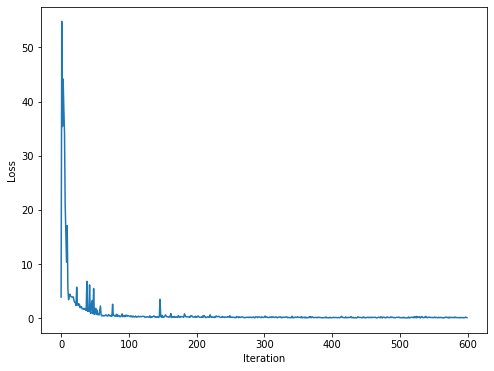

<Figure size 576x432 with 0 Axes>

CPU times: user 3min 38s, sys: 1.94 s, total: 3min 40s
Wall time: 3min 40s


In [ ]:
%%time
print("Train set size: ", dataset_train.length)
print("Test set size: ", dataset_test.length)

losses, y_predict, y_actual = run(dataset_train=dataset_train, dataset_test=dataset_test)

print("Final loss:", sum(losses[-100:])/100)
plot_loss(losses)

fig2 = pyplot.figure()
fig2.set_size_inches(8,6)
pyplot.show()

In [ ]:
def comparer(y_actual, y_predict):
  '''Compares actual and predicted values of y by selecting the argmax
  for each entry. Returns two vectors of the argmax positions as well as the percentage
  of matches.'''
  y_actual_i, y_predict_i = [], []
  matches = 0
  for a, p in zip(y_actual, y_predict):
    y_actual_i.append(np.argmax(a))
    y_predict_i.append(np.argmax(p))
    if np.argmax(a) == np.argmax(p):
      matches += 1

  return y_actual_i, y_predict_i, matches/len(y_actual_i)

In [ ]:
y_actual_i, y_predict_i, match_percent = comparer(y_actual, y_predict)

In [ ]:
match_percent

0.9678515420805018

In [ ]:
accuracy_score(y_actual_i, y_predict_i)

0.9678515420805018

In [ ]:
print(classification_report(y_actual_i, y_predict_i, target_names=y_index_key.keys()))


                            precision    recall  f1-score   support

            Adipose Tissue       0.89      0.99      0.94       103
             Adrenal Gland       1.00      1.00      1.00        26
             Adrenal gland       1.00      0.93      0.97        15
                 Bile duct       0.60      0.67      0.63         9
                   Bladder       0.96      0.99      0.97        87
                     Blood       1.00      1.00      1.00        89
              Blood Vessel       0.96      0.99      0.98       121
               Bone Marrow       1.00      1.00      1.00        14
                     Brain       1.00      1.00      1.00       369
                    Breast       1.00      0.94      0.97       278
                    Cervix       0.90      0.97      0.93        62
              Cervix Uteri       0.00      0.00      0.00         2
                     Colon       0.86      0.97      0.91       128
               Endometrium       0.86      0.93

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Part 1

### 1.1
*How many training examples are in the dataset?*

len(dataset_train) = **15300**

### 1.2.
*What proportion (%) of the full dataset has been set aside for testing?*

len(dataset_test) / (len(dataset_test) + len(dataset_train)) = **20%**

### 1.3.
*How many gene expression values will be used as input to classify each sample in the dataset?*

np.load(x_train_path)['a'].shape(1) = **5172**

### 1.4.
*How many tissue types are there in the data labels?*

len(y_index_key) = **46** (although Adrenal G/gland seems to have been accidentally included twice)

### 1.5.
*When performing classification with a neural network, the output vector is an array with n variables, where each variable describes the probability that your input belongs to one class in your classification problem. Based on this information, what should be the size of your output layer in the neural network?*

**46**

6. *How will you know which index in the output corresponds to which tissue type once you feed your data into the model and get your output?*

**The index in the output will match the value/position of the key in y_index_key dictionary**


## Part 2

### 2.1
*Include a very brief explanation about the purpose they serve, and very briefly describe each of their inputs and outputs*

 - train(): calls train_batch() for each epoch and tracks the loss
    - input:
      - model: neural network graph
      - loader: data_loader object
      - optimizer: object that calculates loss function
      - loss_fn: calculates loss (some function we want to minimize)
      - epochs: number of iterations through data
    - output: an updated model

 - train_batch(): basic training template, performs gradient descent
    - input:
      - model: neural network graph
      - x: training features
      - y: training output
      - optimizer: object that calculates loss function
      - loss_fn: calculates loss (some function we want to minimize)
    - output:
      - updated weights

 - test_batch(): predicts the value of "y"
    - input:
      - model: the trained model from train()
      - x: testing features
      - y: testing output
    - output:
      - y: actual testing output
      - y_predict: predicted value of y

 - test()
    - input:
      - model: the trained model from train()
      - loader:  data_loader object
    - output:
      - y_predict_vector: vector of predicted "y"s

 - plot_loss(): plots loss for each iteration
    - input:
      - losses  
    - output:
      - pyplot figure

 - run():  meta method in which hyperparameters can be set and training/testing methods are called from.
    - input:
      - dataset_train: train set
      - dataset_test: test set
    - output:
      - loss: the loss vector from train()
      - y_predict: predicted

- comparer(): Compares actual and predicted values of y by selecting the argmax for each entry. Returns two vectors of the argmax positions as well as the percentage of matches.
  - input:
    - y_actual: vector of actual observations
    - y_predict: vector of predicted tissue types
  - output:
    - y_actual_i: vector containing argmax(y_actual)
    - y_predict_i: vector containing argmax(y_predict)
    - matches: percentage of matching entries between y_actual_i and y_predic_i

ShallowLinear(): initializes neural network (NN)
  - init(): sets size of NN and the types of layers
  - forward(): sets linear layer functions and activation function  
  
### 2.2
https://drive.google.com/file/d/1SN3Qp4qIN-zcxsxu-LMi7_xGHqj5EUmf/view?usp=sharing

### 2.3
(Completed in code)

## Part 3
### 3.1
*Once your model consistently obtains a reasonable loss (usually below 1) you can start working on assessing its performance. Describe the changes you made.*  
  
In order to achieve Final loss: 0.016383526921272276

I made the following changes:  
1. batch_size_train = 128
2. learning rate = 1e-3
3. epochs = 4
4. Layers as follows:
  - D_in, H1, H2, D_out = [5172, 2609, 1328, 46]
  - with relu activation function from D_in to H1 and H1 to H2

### 3.2
*Print the shapes of these arrays to ensure they are exactly the same dimensions. What are their dimensions?*  
  
y_actual.shape = **(3826, 46)**  
y_predict.shape = **(3826, 46)**

### 3.3
*Do these match your test set size from part 1?*  

Yes  
dataset_test.y_data.shape = **(3826, 46)**

In [ ]:
#@title 3.4

print("y_predict \t y")
print('-'*20)
for p, a in zip(y_predict[0], y_actual[0]):
  print(round(p,3),'\t\t', int(a))

y_predict 	 y
--------------------
-0.009 		 0
-0.051 		 0
-0.028 		 0
0.019 		 0
0.027 		 0
0.057 		 0
0.066 		 0
0.006 		 0
0.693 		 1
0.152 		 0
0.112 		 0
-0.006 		 0
-0.037 		 0
0.048 		 0
0.023 		 0
0.017 		 0
-0.002 		 0
-0.097 		 0
0.045 		 0
-0.05 		 0
0.017 		 0
0.058 		 0
-0.044 		 0
-0.016 		 0
0.082 		 0
0.05 		 0
0.027 		 0
0.0 		 0
0.058 		 0
0.001 		 0
0.057 		 0
-0.01 		 0
-0.017 		 0
-0.022 		 0
0.033 		 0
0.096 		 0
-0.081 		 0
0.046 		 0
0.029 		 0
-0.096 		 0
-0.067 		 0
0.016 		 0
0.068 		 0
-0.125 		 0
-0.009 		 0
0.01 		 0


### 3.5
*Print the shape of your argmax vectors to verify they have n entries. Write the first value of y_argmax and y_predict_argmax and compare them to the table you made in #4. Does the relationship between these values and your #4 values make sense. Do you expect the y_predict argmax to match your truth set?*

len(y_actual_i) = **3826**  
len(y_predict_i) = **3826**  
  
y_actual_i[0] = **8**  
y_predict_i[0] = **8**
  
Yes these match the values in #4. I expect that in a well-trained model the y_predict argmax will match the truth set. Whether mine is such a model is somewhat questionable, so I do not necessarily expect it to match well yet.

### 3.6
*Add to your above method to calculate the percentage of matches between your predictions and known values. What is your overall classification accuracy?*  
match_percent = **0.8892** (* 100%) = **88.92%**


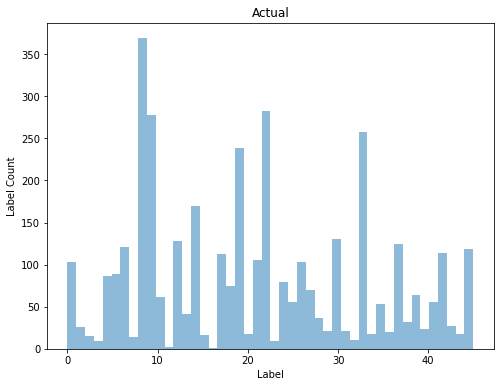

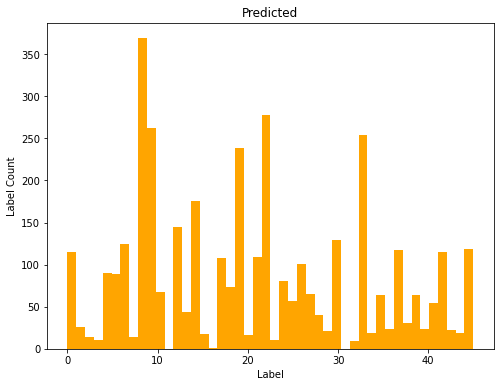

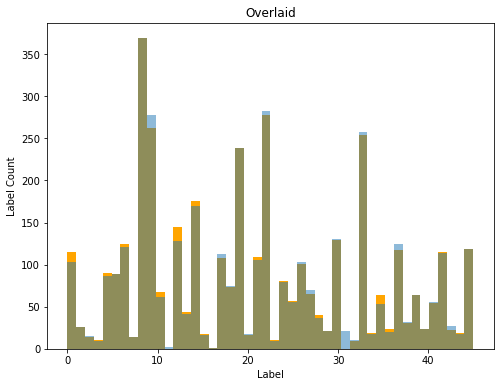

In [ ]:
#@title 3.7 Plot a histogram of your argmax values for y, and for predicted y. (I accidently replotted the histogram after doing some additional optimizations so it looks like the overlap is better than 88.92%)
fig = pyplot.figure()
fig.set_size_inches(8,6)
pyplot.hist(y_actual_i, bins=46, alpha=0.5)
pyplot.title("Actual")
pyplot.ylabel("Label Count")
pyplot.xlabel("Label")
pyplot.show()

fig = pyplot.figure()
fig.set_size_inches(8,6)
pyplot.hist(y_predict_i, bins=46, color='orange')
pyplot.title("Predicted")
pyplot.ylabel("Label Count")
pyplot.xlabel("Label")
pyplot.show()

fig = pyplot.figure()
fig.set_size_inches(8,6)
pyplot.hist(y_predict_i, bins=46, color='orange')
pyplot.hist(y_actual_i, bins=46, alpha=0.5)
pyplot.title("Overlaid")
pyplot.ylabel("Label Count")
pyplot.xlabel("Label")
pyplot.show()

*How do they compare? In which scenarios would you expect your predicted distribution to match or not match your true distribution?*

The histograms seem to match pretty well, which is not too surprising given the relatively high match percent. In the case of a not very well trained model or an overtrained model I expect matching to be quite bad. In the case of a well tuned, general model I expect the true and predicted distributions to be similar.



### 4
(Changes applied to code.)

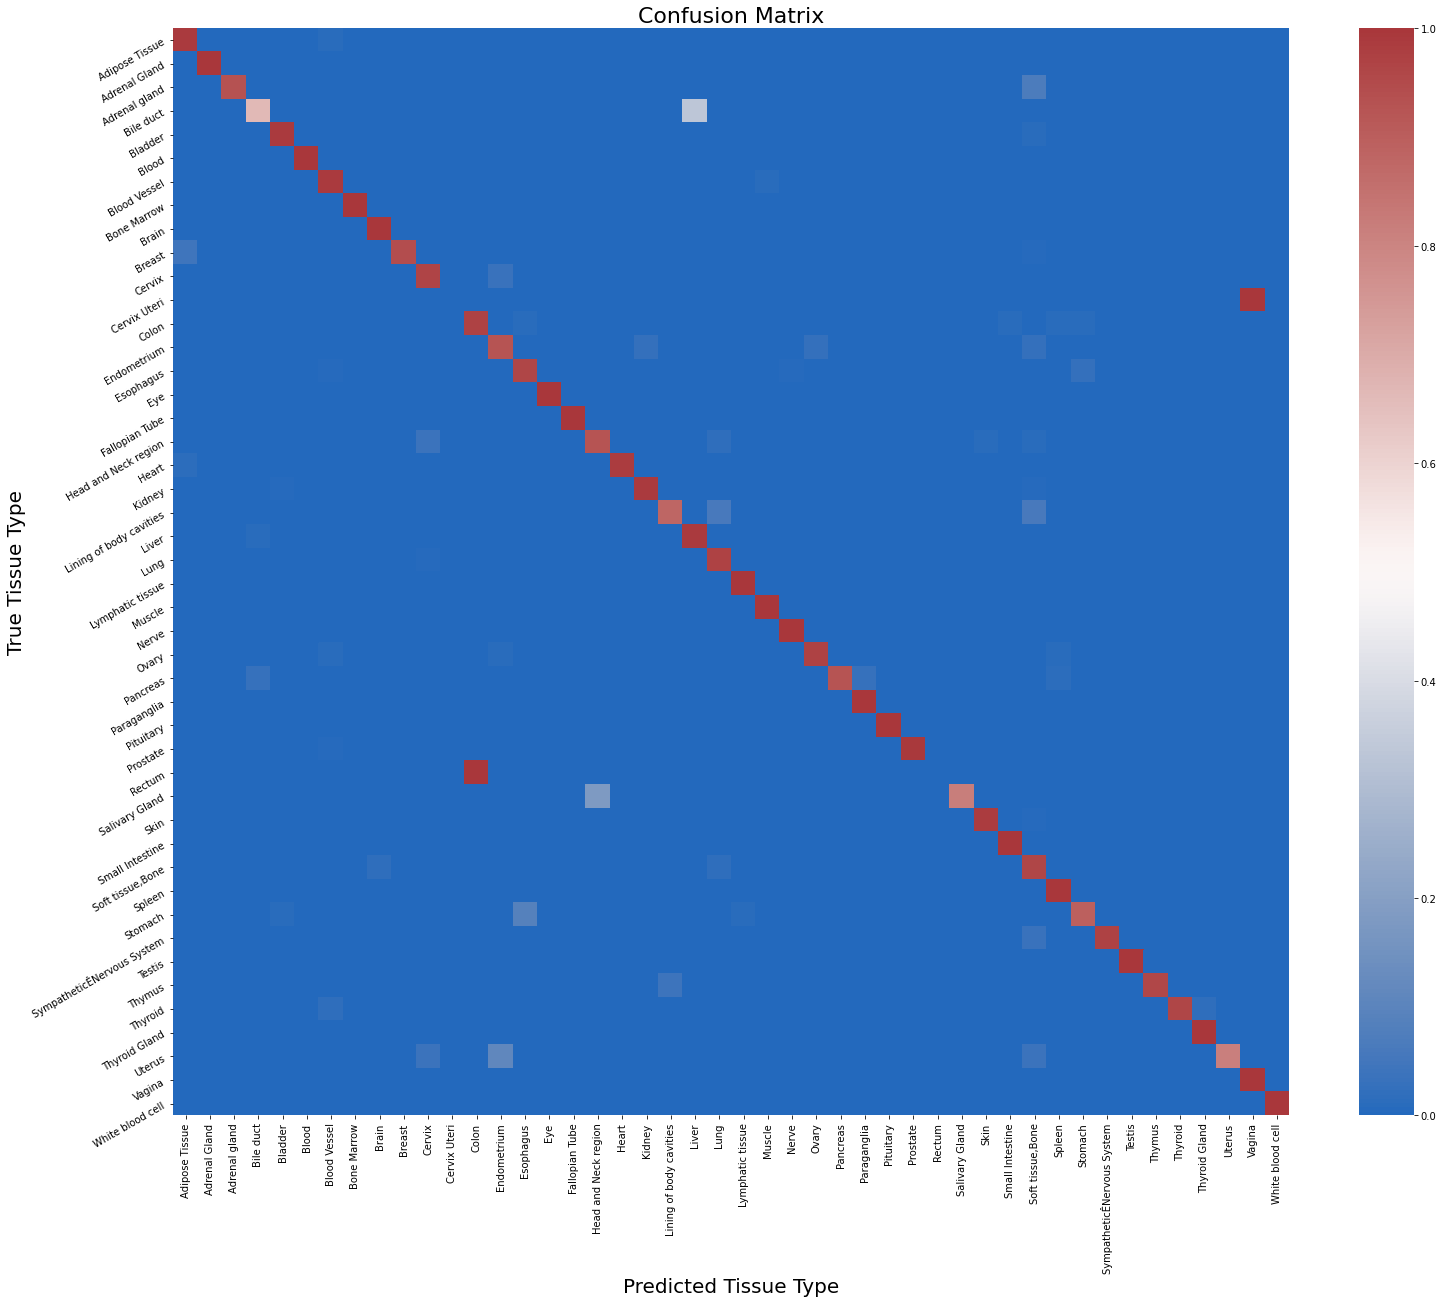

In [ ]:
#@title 5.1
cf_matrix = confusion_matrix(y_actual_i, y_predict_i, normalize='true')

pyplot.subplots(figsize=(25, 20))

ax = pyplot.axes()
#sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=False, cmap ="vlag")
sns.heatmap(cf_matrix, annot=False, cmap ="vlag")
ax.set_title('Confusion Matrix', size=22)
ax.set_xlabel("Predicted Tissue Type", size = 20)
ax.set_yticklabels(list(y_index_key.keys()), rotation='30', fontsize=10)
ax.set_xticklabels(list(y_index_key.keys()), rotation='vertical', fontsize=10)
ax.set_ylabel("True Tissue Type", size = 20)
pyplot.show()


### 5.2  
*Report how the data was processed (if different from the provided script), your architecture, and your training parameters?*
I focused on changing hyperparameters, so the data is processed in the same way.  
#### Training Parameters:
- Neural Net
  - Layers: Input layer, hidden layer 1, hidden layer 2, output layer
  - Nodes: 5172, 2609, 1328, 46
  - Activation functions: relu in both cases
- Training rate: 1e-3
- Batch size: 128
- Epochs: 5
- Optimizer: Adam

### 5.3  
*What is your final accuracy (overall percent)?*  
**accuracy_score(y_actual_i, y_predict_i) = 96.79%**

### 5.4  
*What tissue types were most “confusing” for the model?*  
In many cases confusion seems to be high between similar tissue types. For example the following show relatively high confusion:
- colon and rectum  
- esophagus and stomach  
- breast and adipose  
- bile duct and liver  
- endometrium and uterus  
- cervix and vagina
One interesting finding is the very impressive ability to differentiate between Adrenal **G**land and Adrenal **g**land. Presumably these are quite similar, yet they have f1 score of 1.00 and 0.97 respectively.   
Additionally the model generally performed worse when the number of samples were lower.

### 5.5
*How does each class’s frequency correlate (if at all) to the model’s performance for that class, generally?*  
Below I plot the F1 Score as a function of Support (number samples). We can see that there is a positive correlation between number of samples and proper classification. Below I remove some obvious outliers and the trend remains.



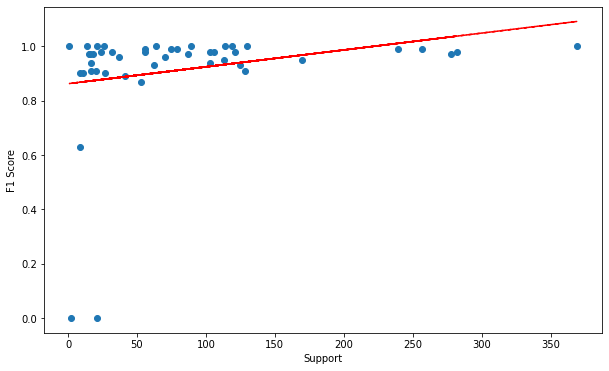

In [ ]:
#@title F1 Score vs. Support
pyplot.subplots(figsize=(10, 6))
support = [103, 26, 15, 9, 87, 89, 121, 14, 369, 278, 62, 2, 128, 41, 170, 16, 1, 113, 75, 239, 17, 106, 282, 9, 79, 56, 103, 70, 37, 21, 130, 21, 11, 257, 18, 53, 20, 125, 32, 64, 24, 56, 114, 27, 17, 119]
f1_score = [0.94, 1.00, 0.97, 0.63, 0.97, 1.00, 0.98, 1.00, 1.00, 0.97, 0.93, 0.00, 0.91, 0.89, 0.95, 0.97, 1.00, 0.95, 0.99, 0.99, 0.91, 0.98, 0.98, 0.90, 0.99, 0.99, 0.98, 0.96, 0.96, 1.00, 1.00, 0.00, 0.90, 0.99, 0.97, 0.87, 0.91, 0.93, 0.98, 1.00, 0.98, 0.98, 1.00, 0.90, 0.94, 1.00]
ax = pyplot.axes()
ax.set_xlabel("Support")
ax.set_ylabel("F1 Score")

pyplot.plot(support,f1_score,'o')

# calc the trendline
z = np.polyfit(support, f1_score, 1)
p = np.poly1d(z)
pyplot.plot(support,p(support),"r--")
print("")



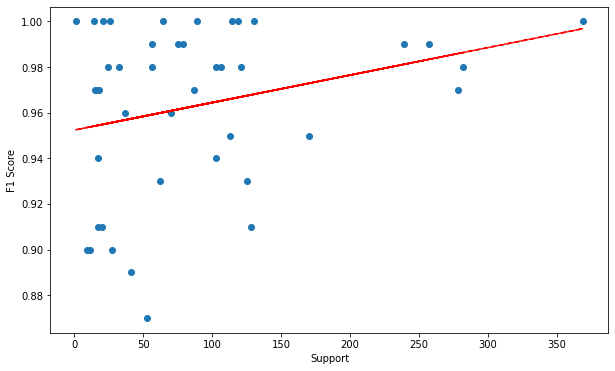

In [ ]:
#@title F1 Score vs. Support (Removed 3 Outliers)
pyplot.subplots(figsize=(10, 6))
support = [103, 26, 15, 87, 89, 121, 14, 369, 278, 62, 128, 41, 170, 16, 1, 113, 75, 239, 17, 106, 282, 9, 79, 56, 103, 70, 37, 21, 130, 11, 257, 18, 53, 20, 125, 32, 64, 24, 56, 114, 27, 17, 119]
f1_score = [0.94, 1.00, 0.97, 0.97, 1.00, 0.98, 1.00, 1.00, 0.97, 0.93, 0.91, 0.89, 0.95, 0.97, 1.00, 0.95, 0.99, 0.99, 0.91, 0.98, 0.98, 0.90, 0.99, 0.99, 0.98, 0.96, 0.96, 1.00, 1.00, 0.90, 0.99, 0.97, 0.87, 0.91, 0.93, 0.98, 1.00, 0.98, 0.98, 1.00, 0.90, 0.94, 1.00]
ax = pyplot.axes()
ax.set_xlabel("Support")
ax.set_ylabel("F1 Score")

pyplot.plot(support,f1_score,'o')

# calc the trendline
z = np.polyfit(support, f1_score, 1)
p = np.poly1d(z)
pyplot.plot(support,p(support),"r--")
print("")


### 5.6  
*Describe your strategy for choosing parameters. Did you use any form of evaluation to inform your decisions?*

**Plots of my findings are below**

The data was processed in the same manner as the original script.  
The metric I was most interested in optimizing was **accuracy**, although I also considered loss and the time required to train the model.

1. I first set the hidden layers
 - I chose 2 hidden layers. This resulted in low loss, high accuracy and low run time ~70 seconds (after resetting the learning rate).
 - For the number of nodes I chose the first layer to be the average the input and output size **(5172 + 46) / 2 = 2609** and the second layer to be the average of the first hidden layer and the output size: **(2609 + 46)/2 = 1328**. I did this based on advice I read that average of the inputs and outputs as the number of the nodes in the in between layer is generally a good starting place

2. I changed the learning rate to 1e-3 and the batch size to 128. These changes greatly reduced the running time, allowing me to test other hyperparameters relatively quickly.

3. Next I tested the effect of changing the number of epochs.
  - I ran the test with epochs = 1, 2, ..., 29.
  - I was surprised to find that by epochs = 2, the loss and accuracy were already quite good 0.93 and 0.23 respectively.
  - After epoch 5 The accuracy remained between 0.95 - 0.975 except for a dip at epoch 22.
  - The loss took longer to stabilize but appears to have stabilized around epoch 23 with no improvement thereafter.  

I chose to proceed with 5 epochs as this produced high accuracy, 96%, while being relatively non-demanding in terms of computation time.

4. Finally I tested various batch sizes in powers of 2: (16, 32, 64, ... 4096)
 - I found a batch size of 128 to be quite good in terms of high accuracy and low loss.
 - Batch sizes higher than this resulted in much larger loss and a drop in accuracy
 - Batch sizes smaller than this actually seemed to perform slightly worse and took much longer to run


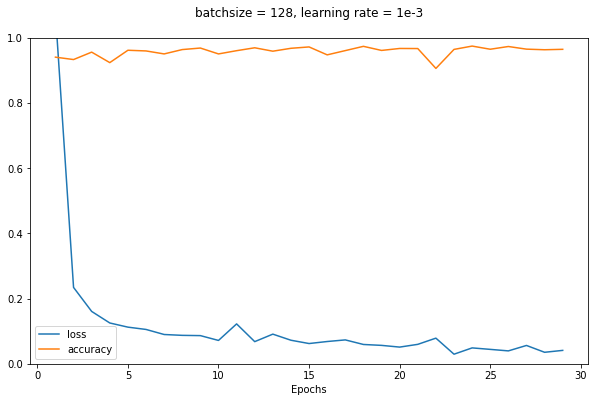

In [ ]:
#@title Accuracy and Loss vs Number of Epochs
pyplot.subplots(figsize=(10, 6))
epochs = range(1,30)
loss = [1.0745324338972568, 0.23419149607419967, 0.16056384723633527, 0.12514481209218503, 0.11239689938724041, 0.1053276556264609, 0.08982321394141764, 0.08721939938142896, 0.08641102826222777, 0.07163206945173442, 0.12232292086817324, 0.06796171502210199, 0.09093960743397474, 0.07224394077435135, 0.062119429078884424, 0.06832650486379861, 0.07326950250193477, 0.059254709479864685, 0.05648756460752338, 0.05121174156898633, 0.059636654127389194, 0.07865997439832427, 0.029442700413055717, 0.04875952806090936, 0.044219745451700876, 0.03958769570570439, 0.056245928020216523, 0.03530489814118482, 0.04113744192698505]
acc = [0.9401463669628856, 0.9328280188186096, 0.9555671719811814, 0.9234187140616832, 0.9613173026659697, 0.9592263460533194, 0.9500784108729744, 0.96340825927862, 0.9681129116570831, 0.9500784108729744, 0.9600104547830632, 0.968897020386827, 0.9584422373235756, 0.9673288029273392, 0.9715107161526398, 0.9472033455305803, 0.9602718243596445, 0.9733403031887088, 0.9607945635128071, 0.9668060637741767, 0.9665446941975954, 0.9056455828541558, 0.9639309984317825, 0.9741244119184527, 0.9644537375849451, 0.9728175640355463, 0.9647151071615264, 0.9628855201254574, 0.9641923680083638]
ax = pyplot.axes()
ax.set_title("batchsize = 128, learning rate = 1e-3\n")
ax.set_xlabel("Epochs")
ax.set(ylim=(0.0, 1))
ax.plot(epochs, loss, label="loss")
ax.plot(epochs, acc, label="accuracy")
ax.legend()
print("")


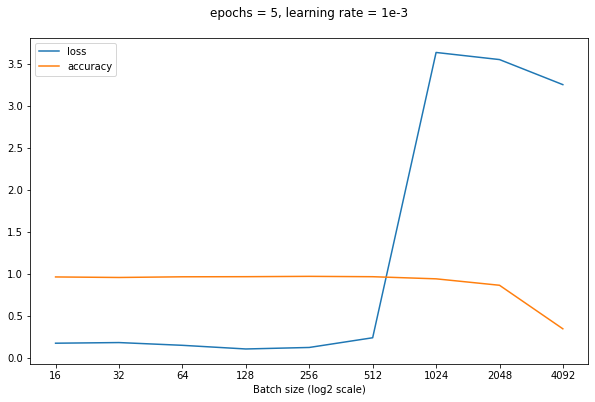

In [ ]:
#@title Accuracy and Loss vs Batchsize
pyplot.subplots(figsize=(10, 6))
batchsize= [16, 32, 64, 128, 256, 512, 1024, 2048, 4092]
batchsize_lg2 = [log2(x) for x in batchsize]
acc = [0.9600104547830632, 0.9537375849451124, 0.9618400418191323, 0.9631468897020387, 0.967067433350758, 0.9628855201254574, 0.9375326711970726, 0.8609513852587559, 0.3423941453214846]
loss = [0.17074373669012857, 0.1784443265059963, 0.14561150327324868, 0.10205667415633797, 0.12003475911915303, 0.2357235921919346, 3.634017324000597, 3.54935193002224, 3.250829439163208]
ax = pyplot.axes()
ax.set_title("epochs = 5, learning rate = 1e-3\n")
ax.set_xlabel("Batch size (log2 scale)")
#ax.set(ylim=(0.0, 1))
ax.set_xticklabels([16] + batchsize)
ax.plot(batchsize_lg2, loss, label="loss")
ax.plot(batchsize_lg2, acc, label="accuracy")
ax.legend()
print("")


### 5.7  
*Assume you have a network with the following dimensions:*  
 - *Input: 32 nodes*  
 - *Hidden: 64 nodes*  
 - *Output: 4 nodes*  
*What is the total number of weight parameters you are optimizing?*  
**32 * 64 + 4 * 64 = 2304 weight parameters**  
*What is the total number of bias parameters you are optimizing?*  
**64 + 4 = 68 bias parameters**  

*For your network, how many weight parameters are you optimizing? How does this compare to the number of training examples in your dataset?*  
**number of training samples: 15300**  
**number of weight parameters: 5172 \* 2609 + 2609 \* 1328 + 1328 \* 46 = 17,019,588**    
**The number of weight parameters is ~1000 fold greater than the number of training samples.**

### 5.8  
*Given these numbers, do you think there is any risk of overfitting? Considering the size and diversity of this test set would you be confident that this model will generalize to all future data you might encounter?*  

This could definitely lead to overfitting because the degrees of freedom in the model are enough to account for every observed sample. I would not be confident that this model would generalize well.

### 5.9  
*Do you think there is a better combination of hyperparameters (not parameters) with respect to the test results?*  
The hyperparameter space is functionally infinite and I've only sampled a small portion of it. Furthermore I expect I expect that tweaking one hyperparameter will affect the optimal value of others, requiring further tweaking. As such I have to assume that a better set of hyperparameters could be idenftified. To be more particular: I never tested changing the number of layers or number of nodes in those layers, so I have little idea of how optimized they are. I also did not try alternative activation functions.

### 5.10  
*Other than the hyperparameters, what might affect this model’s performance?*  
- The quality **and** quantity of the data are important considerations. Bad or inconsistent data collection could result in a non-generalizable model not matter the amount of hyper tuning done (garbage in, garbage out). The number of observations is also important. In general the more observations the more generalizable the model will be, given proper tuning.  
- The distribution of observations could also be a significant stumbling block. If there are large differences in the number of observations (as there are in this excercise) then the model may perform better by simply picking the more common observations more frequently. This seems to be happening to some extent: the classes with the lowest support are being misclassified at a higher rate.
- Another discrepancy is relative difference in tissue type. The esophagus and the stomach may be highly similar in terms of gene expression, and therefore be difficult to classify. Maybe meta-classes could be made to resolve this like: upper digestive track, neural tissue, etc.